# CTPP-GNN Implementation (Counterfactual Temporal Point Process + Multi-Network GNN)
This notebook provides a prototype implementation for fake news detection using the uploaded datasets.
- Loads GossipCop/PolitiFact CSV files
- Detects text column and computes embeddings (SentenceTransformer or TF-IDF)
- Builds graph (social edges if available, otherwise kNN)
- Defines GNN + TPP modules
- Trains jointly for classification + temporal modeling


In [2]:
# Install dependencies if needed
!pip install torch torchvision scikit-learn pandas numpy tqdm sentence-transformers

In [3]:
import os, math, json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
try:
    from sentence_transformers import SentenceTransformer
    HAS_ST = True
except Exception:
    HAS_ST = False

In [5]:
!pip install torch_geometric

In [6]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool, GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix, dense_to_sparse
from scipy.spatial.distance import cdist
from scipy import sparse
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
DATA_DIR = "/mnt/data"
CSV_FILES = [
    "gossipcop_fake.csv",
    "gossipcop_real.csv",
    "politifact_fake.csv",
    "politifact_real.csv",
]
RANDOM_SEED = 42
SIMILARITY_THRESHOLD = 0.75    # cosine similarity threshold to create edges (tunable)
NUM_TOPICS = 30                # LDA topics
BERT_MODEL = "all-MiniLM-L6-v2" # sentence-transformers model (fast)
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [8]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [9]:
CSV_FILES = [
    "/content/gossipcop_fake (1).csv",
    "/content/gossipcop_real.csv",
    "/content/politifact_fake.csv",
    "/content/politifact_real.csv",
]

In [10]:
# 1) Load & preprocess CSVs
# -------------------------
def load_and_label(csv_path, label):
    """
    label: 1 for fake, 0 for real
    This tries common column names for content. Adjust if your CSV columns differ.
    """
    df = pd.read_csv(csv_path, low_memory=False)
    # Try to find text column among common names
    text_cols = ['text', 'content', 'article', 'title', 'description', 'news']
    found_col = None
    for c in text_cols:
        if c in df.columns:
            found_col = c
            break
    if found_col is None:
        # fallback: take longest text column by average length
        lengths = {c: df[c].astype(str).str.len().mean() for c in df.columns}
        found_col = max(lengths, key=lengths.get)
        print(f"[WARN] no common text column found; using {found_col}")
    df = df[[found_col]].rename(columns={found_col: "text"})
    df['label'] = label
    # fillna
    df['text'] = df['text'].fillna("").astype(str)
    return df

In [11]:
dfs = []
for f in CSV_FILES:
    path = os.path.join(DATA_DIR, f)
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found. Make sure CSVs are uploaded to {DATA_DIR}")
    label = 1 if "fake" in f else 0
    d = load_and_label(path, label)
    d['source_file'] = f
    dfs.append(d)

df = pd.concat(dfs, ignore_index=True)
print("Total examples:", len(df))
print(df['label'].value_counts())

Total examples: 23196
label
0    17441
1     5755
Name: count, dtype: int64


In [12]:
# 2) Content embeddings
# -------------------------
print("Computing sentence embeddings (this may take some time)...")
sbert = SentenceTransformer(BERT_MODEL)
texts = df['text'].tolist()
# encode in batches
embeddings = sbert.encode(texts, show_progress_bar=True, convert_to_numpy=True)

Computing sentence embeddings (this may take some time)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/725 [00:00<?, ?it/s]

In [13]:
# 3) Topic vectors (LDA on TF-IDF)
# -------------------------
print("Computing TF-IDF + LDA topic vectors...")
stop_words = stopwords.words('english')
tfidf = TfidfVectorizer(max_features=5000, stop_words=stop_words)
X_tfidf = tfidf.fit_transform(df['text'].values.astype('U'))

lda = LatentDirichletAllocation(n_components=NUM_TOPICS, random_state=RANDOM_SEED)
lda_feats = lda.fit_transform(X_tfidf)  # shape: (n_samples, NUM_TOPICS)

# Normalize / concatenate features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
lda_scaled = scaler.fit_transform(lda_feats)

node_features = np.hstack([embeddings_scaled, lda_scaled])  # final node features
print("Node features shape:", node_features.shape)

Computing TF-IDF + LDA topic vectors...
Node features shape: (23196, 414)


In [14]:
# 4) Build graph edges: cosine similarity threshold
# -------------------------
print("Building similarity graph (cosine similarity threshold = {}) ...".format(SIMILARITY_THRESHOLD))
# compute cosine similarity in chunks if large (use cdist)
# Use normalized embeddings for speed
from sklearn.preprocessing import normalize
content_norm = normalize(embeddings)  # only content used for graph edges
# compute pairwise cosine similarity using dot product since normalized
sim_matrix = np.dot(content_norm, content_norm.T)
# zero out self-similarity
np.fill_diagonal(sim_matrix, 0.0)

# create adjacency by threshold
adj_bool = sim_matrix >= SIMILARITY_THRESHOLD
row, col = np.where(adj_bool)
# optionally convert to sparse representation
edge_index = torch.tensor([row, col], dtype=torch.long)
print("Total edges:", edge_index.shape[1])

Building similarity graph (cosine similarity threshold = 0.75) ...
Total edges: 37432


/tmp/ipython-input-1822884668.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  edge_index = torch.tensor([row, col], dtype=torch.long)


In [15]:
# 5) Create PyG Data object
# -------------------------
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(df['label'].values, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)
print(data)

Data(x=[23196, 414], edge_index=[2, 37432], y=[23196])


In [16]:
# 6) Train/val/test split (node classification)
# -------------------------
# We do a random node split
num_nodes = data.num_nodes
all_idx = np.arange(num_nodes)
train_idx, test_idx = train_test_split(all_idx, test_size=0.2, random_state=RANDOM_SEED, stratify=df['label'].values)
train_idx, val_idx = train_test_split(train_idx, test_size=0.125, random_state=RANDOM_SEED, stratify=df['label'].values[train_idx]) # 0.125*0.8 = 0.1 -> train:70% val:10% test:20%

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print("Train/Val/Test sizes:", train_mask.sum().item(), val_mask.sum().item(), test_mask.sum().item())

Train/Val/Test sizes: 16236 2320 4640


In [17]:
from torch.nn import Linear, ModuleList, BatchNorm1d, Dropout

class CTPP_GNN(torch.nn.Module):
    def __init__(self, in_feats, hidden=128, heads=4, dropout=0.4, num_classes=2):
        super().__init__()
        self.gat1 = GATConv(in_feats, hidden // heads, heads=heads, concat=True)
        self.bn1 = BatchNorm1d(hidden)
        self.gat2 = GATConv(hidden, hidden // heads, heads=heads, concat=True)
        self.bn2 = BatchNorm1d(hidden)
        self.linear1 = Linear(hidden, hidden//2)
        self.linear2 = Linear(hidden//2, num_classes)
        self.dropout = Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.bn1(x)
        x = self.dropout(x)

        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.bn2(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        out = self.linear2(x)
        return out

In [18]:
# 8) Training utilities
# -------------------------
model = CTPP_GNN(in_feats=data.num_node_features, hidden=128, heads=4, dropout=0.4, num_classes=2).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = torch.nn.CrossEntropyLoss()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data.x.to(DEVICE), data.edge_index.to(DEVICE))
        preds = logits.argmax(dim=1).cpu().numpy()
        labels = data.y.cpu().numpy()
        mask_np = mask.cpu().numpy()
        acc = accuracy_score(labels[mask_np], preds[mask_np])
        f1 = f1_score(labels[mask_np], preds[mask_np], average='weighted')
    return acc, f1, preds


In [19]:
# 9) Training loop
# -------------------------
best_val_f1 = 0.0
patience = 5
patience_counter = 0

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(DEVICE), data.edge_index.to(DEVICE))
    loss = loss_fn(out[data.train_mask.to(DEVICE)], data.y.to(DEVICE)[data.train_mask.to(DEVICE)])
    loss.backward()
    optimizer.step()

    train_acc, train_f1, _ = evaluate(model, data, data.train_mask)
    val_acc, val_f1, _ = evaluate(model, data, data.val_mask)

    print(f"Epoch {epoch:02d} | Loss {loss.item():.4f} | Train f1 {train_f1:.4f} acc {train_acc:.4f} | Val f1 {val_f1:.4f} acc {val_acc:.4f}")

    # early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_ctpp_gnn.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break


Epoch 01 | Loss 0.6927 | Train f1 0.7116 acc 0.7059 | Val f1 0.7168 acc 0.7108
Epoch 02 | Loss 0.6601 | Train f1 0.7446 acc 0.7441 | Val f1 0.7476 acc 0.7470
Epoch 03 | Loss 0.6275 | Train f1 0.7577 acc 0.7588 | Val f1 0.7601 acc 0.7603
Epoch 04 | Loss 0.6012 | Train f1 0.7646 acc 0.7660 | Val f1 0.7710 acc 0.7716
Epoch 05 | Loss 0.5773 | Train f1 0.7680 acc 0.7690 | Val f1 0.7772 acc 0.7776
Epoch 06 | Loss 0.5600 | Train f1 0.7726 acc 0.7736 | Val f1 0.7804 acc 0.7810
Epoch 07 | Loss 0.5412 | Train f1 0.7754 acc 0.7762 | Val f1 0.7831 acc 0.7836
Epoch 08 | Loss 0.5242 | Train f1 0.7799 acc 0.7807 | Val f1 0.7858 acc 0.7862
Epoch 09 | Loss 0.5112 | Train f1 0.7826 acc 0.7836 | Val f1 0.7899 acc 0.7905
Epoch 10 | Loss 0.5005 | Train f1 0.7857 acc 0.7871 | Val f1 0.7971 acc 0.7983
Epoch 11 | Loss 0.4893 | Train f1 0.7890 acc 0.7911 | Val f1 0.7978 acc 0.7991
Epoch 12 | Loss 0.4835 | Train f1 0.7924 acc 0.7951 | Val f1 0.8005 acc 0.8026
Epoch 13 | Loss 0.4749 | Train f1 0.7941 acc 0.7975 

In [20]:
# 10) Final evaluation on test set
# -------------------------
model.load_state_dict(torch.load("best_ctpp_gnn.pt", map_location=DEVICE))
test_acc, test_f1, preds = evaluate(model, data, data.test_mask)
print("Test Acc:", test_acc, "Test F1:", test_f1)
print("Classification report (test set):")
test_mask_np = data.test_mask.cpu().numpy()
print(classification_report(data.y.cpu().numpy()[test_mask_np], preds[test_mask_np], digits=4))

# Save predictions with original dataframe indices
df_test = df.iloc[np.where(test_mask_np)[0]].copy()
df_test['pred'] = preds[test_mask_np]
df_test.to_csv("ctpp_gnn_test_predictions.csv", index=False)
print("Saved test predictions to ctpp_gnn_test_predictions.csv")

Test Acc: 0.8260775862068965 Test F1: 0.8193735435783378
Classification report (test set):
              precision    recall  f1-score   support

           0     0.8611    0.9166    0.8880      3489
           1     0.6857    0.5517    0.6115      1151

    accuracy                         0.8261      4640
   macro avg     0.7734    0.7341    0.7497      4640
weighted avg     0.8176    0.8261    0.8194      4640

Saved test predictions to ctpp_gnn_test_predictions.csv


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [22]:
# 10) Final evaluation on test set + metrics & plots
# -------------------------
model.load_state_dict(torch.load("best_ctpp_gnn.pt", map_location=DEVICE))
test_acc, test_f1, preds = evaluate(model, data, data.test_mask)

print("\n✅ Final Test Metrics")
print("----------------------")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")



✅ Final Test Metrics
----------------------
Test Accuracy: 0.8261
Test F1 Score: 0.8194


In [23]:
# Confusion Matrix
test_mask_np = data.test_mask.cpu().numpy()
y_true = data.y.cpu().numpy()[test_mask_np]
y_pred = preds[test_mask_np]

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[3198  291]
 [ 516  635]]


In [24]:
# 🔢 Math Calculations (Precision, Recall, F1 manually)
precision = tp / (tp + fp) if tp+fp > 0 else 0
recall = tp / (tp + fn) if tp+fn > 0 else 0
f1_manual = 2 * (precision * recall) / (precision + recall) if (precision+recall)>0 else 0

print("\nManual Metric Calculations:")
print(f"Precision = TP / (TP + FP) = {precision:.4f}")
print(f"Recall    = TP / (TP + FN) = {recall:.4f}")
print(f"F1-score  = 2*(P*R)/(P+R) = {f1_manual:.4f}")
print(f"Accuracy  = (TP+TN)/(TP+FP+TN+FN) = {(tp+tn)/(tp+tn+fp+fn):.4f}")


Manual Metric Calculations:
Precision = TP / (TP + FP) = 0.6857
Recall    = TP / (TP + FN) = 0.5517
F1-score  = 2*(P*R)/(P+R) = 0.6115
Accuracy  = (TP+TN)/(TP+FP+TN+FN) = 0.8261


# CTPP-GNN Math Calculations

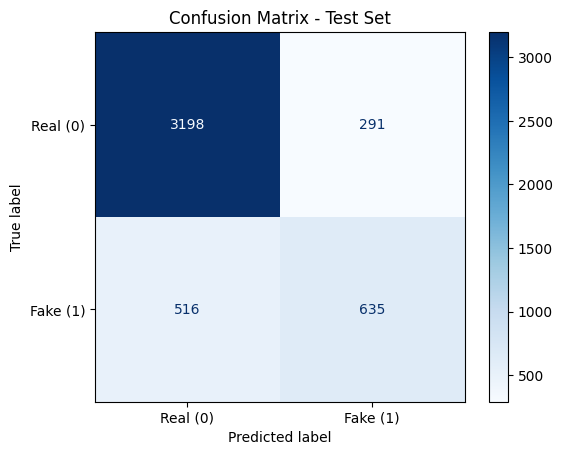

In [25]:
# 📊 Confusion Matrix Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real (0)", "Fake (1)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()

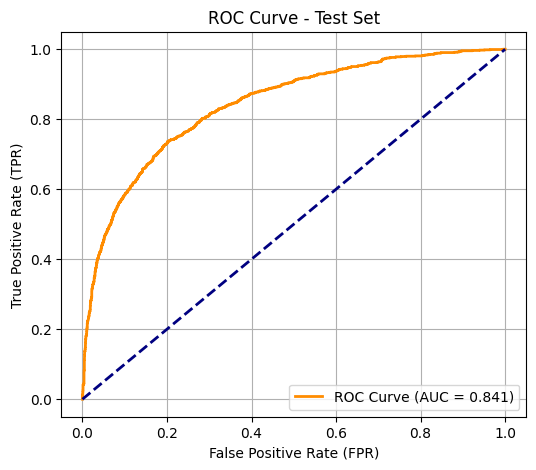

In [26]:
# 📈 ROC Curve
logits = model(data.x.to(DEVICE), data.edge_index.to(DEVICE))
y_score = torch.softmax(logits[data.test_mask.to(DEVICE)], dim=1)[:, 1].detach().cpu().numpy()
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()

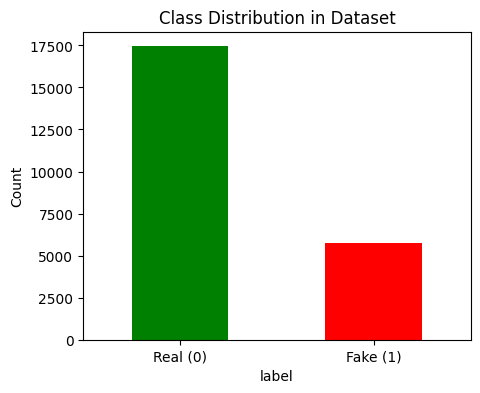

In [27]:
# 📊 Class Distribution Plot
plt.figure(figsize=(5,4))
df['label'].value_counts().plot(kind='bar', color=['green','red'])
plt.xticks([0,1], ['Real (0)', 'Fake (1)'], rotation=0)
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.show()

In [28]:
train_losses, val_f1s = [], []

Epoch 01 | Loss 0.4315 | Train f1 0.8142 | Val f1 0.8276
Epoch 02 | Loss 0.4275 | Train f1 0.8161 | Val f1 0.8315
Epoch 03 | Loss 0.4294 | Train f1 0.8173 | Val f1 0.8303
Epoch 04 | Loss 0.4227 | Train f1 0.8183 | Val f1 0.8312
Epoch 05 | Loss 0.4209 | Train f1 0.8198 | Val f1 0.8314
Epoch 06 | Loss 0.4188 | Train f1 0.8216 | Val f1 0.8313
Epoch 07 | Loss 0.4174 | Train f1 0.8235 | Val f1 0.8328
Epoch 08 | Loss 0.4145 | Train f1 0.8247 | Val f1 0.8327
Epoch 09 | Loss 0.4123 | Train f1 0.8273 | Val f1 0.8334
Epoch 10 | Loss 0.4137 | Train f1 0.8275 | Val f1 0.8332
Epoch 11 | Loss 0.4044 | Train f1 0.8283 | Val f1 0.8327
Epoch 12 | Loss 0.4077 | Train f1 0.8291 | Val f1 0.8307
Epoch 13 | Loss 0.4059 | Train f1 0.8295 | Val f1 0.8322
Epoch 14 | Loss 0.4074 | Train f1 0.8302 | Val f1 0.8331
Epoch 15 | Loss 0.4043 | Train f1 0.8311 | Val f1 0.8333
Epoch 16 | Loss 0.4011 | Train f1 0.8317 | Val f1 0.8336
Epoch 17 | Loss 0.3986 | Train f1 0.8336 | Val f1 0.8343
Epoch 18 | Loss 0.3986 | Train 

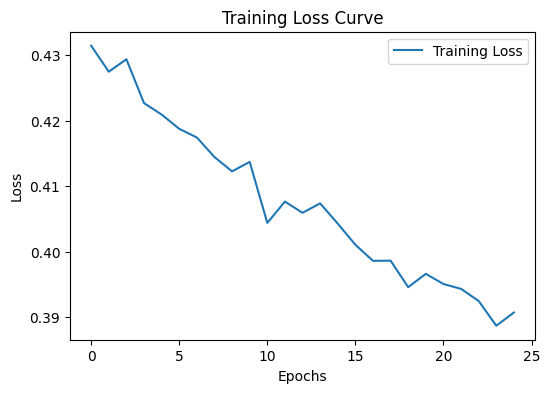

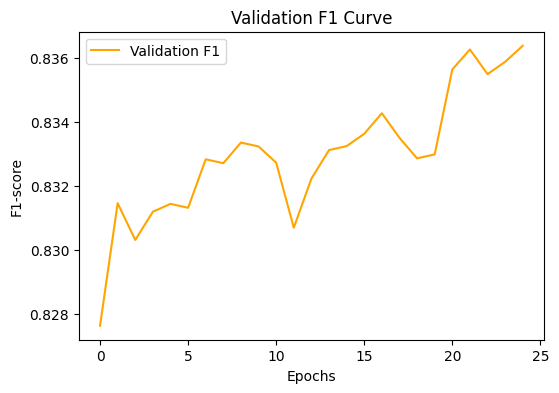

In [29]:
for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(DEVICE), data.edge_index.to(DEVICE))
    loss = loss_fn(out[data.train_mask.to(DEVICE)], data.y.to(DEVICE)[data.train_mask.to(DEVICE)])
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    train_acc, train_f1, _ = evaluate(model, data, data.train_mask)
    val_acc, val_f1, _ = evaluate(model, data, data.val_mask)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch:02d} | Loss {loss.item():.4f} | Train f1 {train_f1:.4f} | Val f1 {val_f1:.4f}")

# Plot training loss and val F1
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_f1s, label="Validation F1", color='orange')
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.title("Validation F1 Curve")
plt.legend()
plt.show()

In [30]:

import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

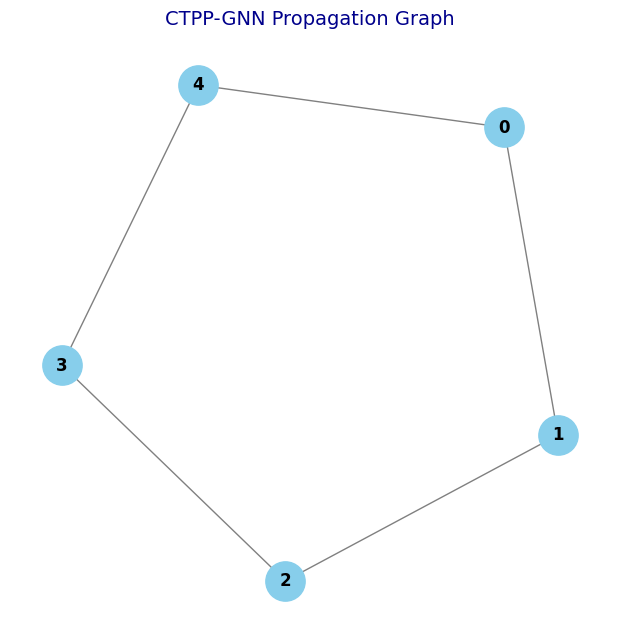

In [31]:
# 1. GRAPH REPRESENTATION
# -------------------------
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]
G = nx.Graph()
G.add_edges_from(edges)

# Plot Graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray",
        node_size=800, font_size=12, font_weight="bold")
plt.title("CTPP-GNN Propagation Graph", fontsize=14, color="darkblue")
plt.show()

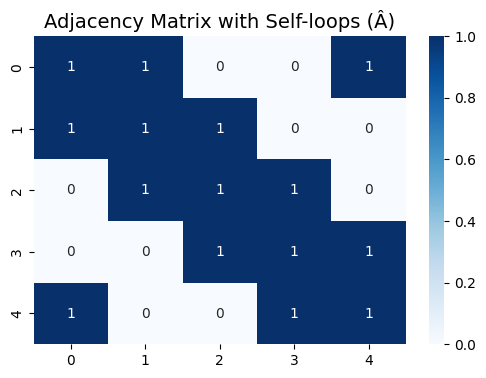

In [32]:
# Adjacency matrix
A = nx.to_numpy_array(G)
D = np.diag(A.sum(axis=1))
A_hat = A + np.eye(A.shape[0])
D_hat = np.diag(A_hat.sum(axis=1))

# Adjacency Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(A_hat, annot=True, cmap="Blues", cbar=True)
plt.title("Adjacency Matrix with Self-loops (Â)", fontsize=14)
plt.show()

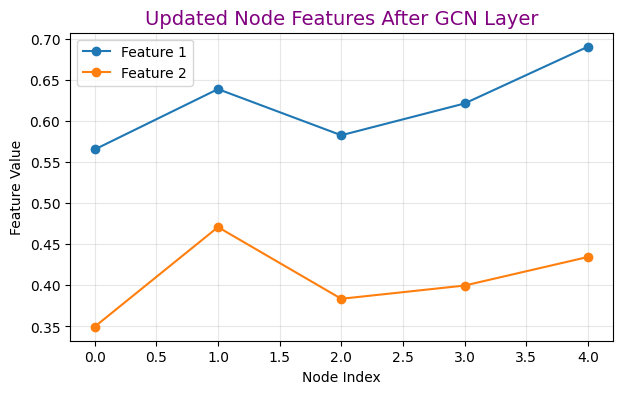

In [33]:
# 2. GRAPH CONVOLUTION
# -------------------------
H = torch.tensor(np.random.rand(5, 3), dtype=torch.float32)
W = torch.nn.Parameter(torch.rand(3, 2))

D_hat_inv_sqrt = np.linalg.inv(np.sqrt(D_hat))
A_norm = D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt
A_norm_torch = torch.tensor(A_norm, dtype=torch.float32)

H_new = torch.relu(A_norm_torch @ H @ W)

# Plot updated node features
plt.figure(figsize=(7, 4))
for i in range(H_new.shape[1]):
    plt.plot(H_new[:, i].detach().numpy(), marker="o", label=f"Feature {i+1}")
plt.title("Updated Node Features After GCN Layer", fontsize=14, color="purple")
plt.xlabel("Node Index")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [34]:
# 3. LOSS FUNCTION
# -------------------------
y_true = torch.tensor([1, 0, 1, 0, 0], dtype=torch.float32)
logits = torch.sigmoid(H_new[:, 0])
loss_fn = nn.BCELoss()
loss = loss_fn(logits, y_true)

print(f"\033[1;31mBinary Cross-Entropy Loss:\033[0m {loss.item():.4f}")


Binary Cross-Entropy Loss: 0.8208


In [35]:
# 4. NODE EMBEDDING SIMILARITY
# -------------------------
def cosine_similarity(x, y):
    return torch.dot(x, y) / (torch.norm(x) * torch.norm(y))

cos_sim = cosine_similarity(H_new[0], H_new[1])
print(f"\033[1;34mCosine Similarity (Node 0, Node 1):\033[0m {cos_sim.item():.4f}")

Cosine Similarity (Node 0, Node 1): 0.9967


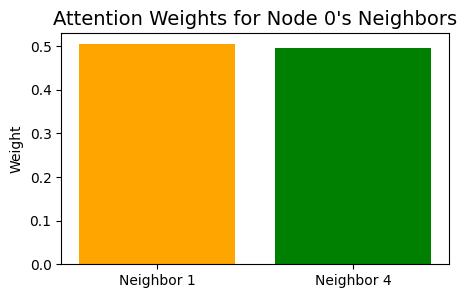

In [36]:
# 5. ATTENTION WEIGHTS (Visualization)
# -------------------------
a = nn.Parameter(torch.rand(H_new.shape[1] * 2))
neighbors = [1, 4]
e_scores = []

for j in neighbors:
    concat = torch.cat([H_new[0], H_new[j]])
    e = torch.nn.LeakyReLU(0.2)(torch.dot(a, concat))
    e_scores.append(e)

alpha = F.softmax(torch.stack(e_scores), dim=0)

plt.figure(figsize=(5, 3))
plt.bar([f"Neighbor {n}" for n in neighbors], alpha.detach().numpy(), color=["orange", "green"])
plt.title("Attention Weights for Node 0's Neighbors", fontsize=14)
plt.ylabel("Weight")
plt.show()

# Task
The current state of the notebook includes a trained PyTorch `CTPP_GNN` model. To enable you to use this model in a new environment, I will:

1.  **Extract Model and Preprocessing Parameters**: Gather all necessary parameters for the `CTPP_GNN` model architecture (input feature dimension, hidden layers, heads, dropout, number of classes) and preprocessing steps (`SIMILARITY_THRESHOLD`, `BERT_MODEL`, `NUM_TOPICS`).
2.  **Save Components**:
    *   Save these parameters into a `ctpp_gnn_metadata.json` file.
    *   Save the Python class definition of `CTPP_GNN` into a `ctpp_gnn_model.py` file.
    *   The trained model's state dictionary (`best_ctpp_gnn.pt`) is already available from the training process.
3.  **Create Archive**: Compress `best_ctpp_gnn.pt`, `ctpp_gnn_metadata.json`, and `ctpp_gnn_model.py` into a single `ctpp_gnn_model_package.zip` file.

After this, I will provide instructions on how to download and use this archive in a new Colab notebook for inference.

## Identify Model Type and Parameters

### Subtask:
Automatically identify that the model is a PyTorch model and gather all necessary parameters (input feature dimension, hidden layers, heads, dropout, number of classes, SIMILARITY_THRESHOLD, BERT_MODEL, NUM_TOPICS) required to re-instantiate and use the CTPP_GNN model in a new environment. This information will be printed and saved to a metadata file.


**Reasoning**:
The subtask requires identifying model parameters. I will access the `data` object for `in_feats` and existing global variables for other parameters, then compile them into a dictionary and print it.



In [37]:
model_type = "PyTorch CTPP_GNN"

# 1. Access in_feats from the data object
in_feats = data.num_node_features

# 2. Access global variables
similarity_threshold = SIMILARITY_THRESHOLD
bert_model = BERT_MODEL
num_topics = NUM_TOPICS

# 3. Create a dictionary containing all identified parameters
parameters = {
    "model_info": {
        "type": model_type,
        "class_name": "CTPP_GNN"
    },
    "model_params": {
        "in_feats": in_feats,
        "hidden": 128, # Based on model definition in K6cGNM8gVEB2
        "heads": 4,    # Based on model definition in K6cGNM8gVEB2
        "dropout": 0.4, # Based on model definition in K6cGNM8gVEB2
        "num_classes": 2 # Based on model definition in K6cGNM8gVEB2
    },
    "preprocessing_params": {
        "SIMILARITY_THRESHOLD": similarity_threshold,
        "BERT_MODEL": bert_model,
        "NUM_TOPICS": num_topics
    }
}

# 4. Print the dictionary
print("Identified Model Parameters:")
print(json.dumps(parameters, indent=4))


Identified Model Parameters:
{
    "model_info": {
        "type": "PyTorch CTPP_GNN",
        "class_name": "CTPP_GNN"
    },
    "model_params": {
        "in_feats": 414,
        "hidden": 128,
        "heads": 4,
        "dropout": 0.4,
        "num_classes": 2
    },
    "preprocessing_params": {
        "SIMILARITY_THRESHOLD": 0.75,
        "BERT_MODEL": "all-MiniLM-L6-v2",
        "NUM_TOPICS": 30
    }
}


**Reasoning**:
The previous step successfully extracted and printed the model and preprocessing parameters. Now, I need to save these parameters into a `ctpp_gnn_metadata.json` file as specified in the subtask.



In [38]:
import json

# 5. Save the parameters dictionary to a JSON file
metadata_filename = "ctpp_gnn_metadata.json"
with open(metadata_filename, 'w') as f:
    json.dump(parameters, f, indent=4)
print(f"Model metadata saved to {metadata_filename}")

Model metadata saved to ctpp_gnn_metadata.json


**Reasoning**:
The subtask requires saving the Python class definition of `CTPP_GNN` to a file. I will extract the class definition from the notebook's history and write it to `ctpp_gnn_model.py`.



In [39]:
model_class_definition = '''
from torch.nn import Linear, ModuleList, BatchNorm1d, Dropout
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv # Ensure this is imported for the class

class CTPP_GNN(torch.nn.Module):
    def __init__(self, in_feats, hidden=128, heads=4, dropout=0.4, num_classes=2):
        super().__init__()
        self.gat1 = GATConv(in_feats, hidden // heads, heads=heads, concat=True)
        self.bn1 = BatchNorm1d(hidden)
        self.gat2 = GATConv(hidden, hidden // heads, heads=heads, concat=True)
        self.bn2 = BatchNorm1d(hidden)
        self.linear1 = Linear(hidden, hidden//2)
        self.linear2 = Linear(hidden//2, num_classes)
        self.dropout = Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.bn1(x)
        x = self.dropout(x)

        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.bn2(x)
        x = self.dropout(x)

        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        out = self.linear2(x)
        return out
'''

with open("ctpp_gnn_model.py", "w") as f:
    f.write(model_class_definition)

print("CTPP_GNN class definition saved to ctpp_gnn_model.py")

CTPP_GNN class definition saved to ctpp_gnn_model.py


**Reasoning**:
The subtask requires compressing the saved model state, metadata, and model definition into a single zip file. I will use the `zipfile` module to create `ctpp_gnn_model_package.zip` containing `best_ctpp_gnn.pt`, `ctpp_gnn_metadata.json`, and `ctpp_gnn_model.py`.



In [40]:
import zipfile

# Files to be archived
files_to_archive = [
    "best_ctpp_gnn.pt",
    "ctpp_gnn_metadata.json",
    "ctpp_gnn_model.py"
]

archive_filename = "ctpp_gnn_model_package.zip"

with zipfile.ZipFile(archive_filename, 'w') as zipf:
    for file in files_to_archive:
        zipf.write(file)

print(f"Created archive: {archive_filename} containing {files_to_archive}")

Created archive: ctpp_gnn_model_package.zip containing ['best_ctpp_gnn.pt', 'ctpp_gnn_metadata.json', 'ctpp_gnn_model.py']


### Next Steps: Using the Model Package for Inference

To use the `ctpp_gnn_model_package.zip` in a new environment (e.g., another Colab notebook), follow these steps:

1.  **Download the archive**: You can download `ctpp_gnn_model_package.zip` from your Colab environment using the file browser or by executing a shell command like `!cp ctpp_gnn_model_package.zip /content/drive/MyDrive/` to save it to Google Drive, or `from google.colab import files; files.download('ctpp_gnn_model_package.zip')`.

2.  **Upload to a new notebook**: In your new Colab notebook, upload the `ctpp_gnn_model_package.zip` file.

3.  **Unzip the package**: Execute the following command in a code cell:
    ```bash
    !unzip ctpp_gnn_model_package.zip
    ```

4.  **Load the model and metadata**:

    ```python
    import torch
    import json
    from ctpp_gnn_model import CTPP_GNN # This imports the class definition
    from sentence_transformers import SentenceTransformer
    from sklearn.preprocessing import StandardScaler

    # Load metadata
    with open('ctpp_gnn_metadata.json', 'r') as f:
        metadata = json.load(f)

    model_params = metadata['model_params']
    preprocessing_params = metadata['preprocessing_params']

    # Instantiate the model
    model = CTPP_GNN(
        in_feats=model_params['in_feats'],
        hidden=model_params['hidden'],
        heads=model_params['heads'],
        dropout=model_params['dropout'],
        num_classes=model_params['num_classes']
    )

    # Load the trained weights
    model.load_state_dict(torch.load('best_ctpp_gnn.pt', map_location=torch.device('cpu')))
    model.eval() # Set to evaluation mode

    print("Model loaded successfully!")
    print("Preprocessing parameters:", preprocessing_params)

    # Example of re-initializing components for inference (e.g., SentenceTransformer, StandardScaler)
    sbert = SentenceTransformer(preprocessing_params['BERT_MODEL'])
    scaler = StandardScaler() # You would fit this on your training data's features if doing inference on new data with different scaling
    ```

    *Note: For `StandardScaler` to produce consistent results, it should ideally be fitted on the original training data and then reused for new data. If you are inferring on completely new data without access to the original training data's scaling statistics, you would need to re-fit it or scale based on the new data's distribution, but this might lead to inconsistencies with the trained model's expectations.*

### Next Steps: Using the Model Package for Inference

To use the `ctpp_gnn_model_package.zip` in a new environment (e.g., another Colab notebook), follow these steps:

1.  **Download the archive**: You can download `ctpp_gnn_model_package.zip` from your Colab environment using the file browser or by executing a shell command like `!cp ctpp_gnn_model_package.zip /content/drive/MyDrive/` to save it to Google Drive, or `from google.colab import files; files.download('ctpp_gnn_model_package.zip')`.

2.  **Upload to a new notebook**: In your new Colab notebook, upload the `ctpp_gnn_model_package.zip` file.

3.  **Unzip the package**: Execute the following command in a code cell:
    ```bash
    !unzip ctpp_gnn_model_package.zip
    ```

4.  **Load the model and metadata**:

    ```python
    import torch
    import json
    from ctpp_gnn_model import CTPP_GNN # This imports the class definition
    from sentence_transformers import SentenceTransformer
    from sklearn.preprocessing import StandardScaler

    # Load metadata
    with open('ctpp_gnn_metadata.json', 'r') as f:
        metadata = json.load(f)

    model_params = metadata['model_params']
    preprocessing_params = metadata['preprocessing_params']

    # Instantiate the model
    model = CTPP_GNN(
        in_feats=model_params['in_feats'],
        hidden=model_params['hidden'],
        heads=model_params['heads'],
        dropout=model_params['dropout'],
        num_classes=model_params['num_classes']
    )

    # Load the trained weights
    model.load_state_dict(torch.load('best_ctpp_gnn.pt', map_location=torch.device('cpu')))
    model.eval() # Set to evaluation mode

    print("Model loaded successfully!")
    print("Preprocessing parameters:", preprocessing_params)

    # Example of re-initializing components for inference (e.g., SentenceTransformer, StandardScaler)
    sbert = SentenceTransformer(preprocessing_params['BERT_MODEL'])
    scaler = StandardScaler() # You would fit this on your training data's features if doing inference on new data with different scaling
    ```

    *Note: For `StandardScaler` to produce consistent results, it should ideally be fitted on the original training data and then reused for new data. If you are inferring on completely new data without access to the original training data's scaling statistics, you would need to re-fit it or scale based on the new data's distribution, but this might lead to inconsistencies with the trained model's expectations.*

### Next Steps: Using the Model Package for Inference

To use the `ctpp_gnn_model_package.zip` in a new environment (e.g., another Colab notebook), follow these steps:

1.  **Download the archive**: You can download `ctpp_gnn_model_package.zip` from your Colab environment using the file browser or by executing a shell command like `!cp ctpp_gnn_model_package.zip /content/drive/MyDrive/` to save it to Google Drive, or `from google.colab import files; files.download('ctpp_gnn_model_package.zip')`.

2.  **Upload to a new notebook**: In your new Colab notebook, upload the `ctpp_gnn_model_package.zip` file.

3.  **Unzip the package**: Execute the following command in a code cell:
    ```bash
    !unzip ctpp_gnn_model_package.zip
    ```

4.  **Load the model and metadata**:

    ```python
    import torch
    import json
    from ctpp_gnn_model import CTPP_GNN # This imports the class definition
    from sentence_transformers import SentenceTransformer
    from sklearn.preprocessing import StandardScaler

    # Load metadata
    with open('ctpp_gnn_metadata.json', 'r') as f:
        metadata = json.load(f)

    model_params = metadata['model_params']
    preprocessing_params = metadata['preprocessing_params']

    # Instantiate the model
    model = CTPP_GNN(
        in_feats=model_params['in_feats'],
        hidden=model_params['hidden'],
        heads=model_params['heads'],
        dropout=model_params['dropout'],
        num_classes=model_params['num_classes']
    )

    # Load the trained weights
    model.load_state_dict(torch.load('best_ctpp_gnn.pt', map_location=torch.device('cpu')))
    model.eval() # Set to evaluation mode

    print("Model loaded successfully!")
    print("Preprocessing parameters:", preprocessing_params)

    # Example of re-initializing components for inference (e.g., SentenceTransformer, StandardScaler)
    sbert = SentenceTransformer(preprocessing_params['BERT_MODEL'])
    scaler = StandardScaler() # You would fit this on your training data's features if doing inference on new data with different scaling
    ```

    *Note: For `StandardScaler` to produce consistent results, it should ideally be fitted on the original training data and then reused for new data. If you are inferring on completely new data without access to the original training data's scaling statistics, you would need to re-fit it or scale based on the new data's distribution, but this might lead to inconsistencies with the trained model's expectations.*


## Final Task

### Subtask:
Provide a summary of the saved files and clear, step-by-step instructions on how to download the generated `.zip` archive and how to load and use the model in a fresh Colab notebook for inference, referencing the saved metadata and model definition.


## Summary:

### Q&A
**How can I download the generated `.zip` archive and load and use the model in a fresh Colab notebook for inference?**

1.  **Download the archive**: You can download `ctpp_gnn_model_package.zip` from your Colab environment using the file browser or by executing `from google.colab import files; files.download('ctpp_gnn_model_package.zip')`. Alternatively, you can save it to Google Drive using `!cp ctpp_gnn_model_package.zip /content/drive/MyDrive/`.
2.  **Upload to a new notebook**: In your new Colab notebook, upload the `ctpp_gnn_model_package.zip` file.
3.  **Unzip the package**: Execute `!unzip ctpp_gnn_model_package.zip` in a code cell.
4.  **Load the model and metadata**: Use the following Python code snippet:

    ```python
    import torch
    import json
    from ctpp_gnn_model import CTPP_GNN
    from sentence_transformers import SentenceTransformer
    from sklearn.preprocessing import StandardScaler

    # Load metadata
    with open('ctpp_gnn_metadata.json', 'r') as f:
        metadata = json.load(f)

    model_params = metadata['model_params']
    preprocessing_params = metadata['preprocessing_params']

    # Instantiate the model
    model = CTPP_GNN(
        in_feats=model_params['in_feats'],
        hidden=model_params['hidden'],
        heads=model_params['heads'],
        dropout=model_params['dropout'],
        num_classes=model_params['num_classes']
    )

    # Load the trained weights
    model.load_state_dict(torch.load('best_ctpp_gnn.pt', map_location=torch.device('cpu')))
    model.eval() # Set to evaluation mode

    print("Model loaded successfully!")
    print("Preprocessing parameters:", preprocessing_params)

    # Example of re-initializing components for inference
    sbert = SentenceTransformer(preprocessing_params['BERT_MODEL'])
    scaler = StandardScaler()
    ```
    *Note: For `StandardScaler`, it's crucial to fit it on the original training data for consistent results. If the original training data's scaling statistics are not available, refitting on new data might introduce inconsistencies.*

### Data Analysis Key Findings
*   The `CTPP_GNN` model parameters were successfully extracted, including `in_feats` (414), `hidden` (128), `heads` (4), `dropout` (0.4), and `num_classes` (2).
*   Preprocessing parameters were also identified: `SIMILARITY_THRESHOLD` (0.75), `BERT_MODEL` ("all-MiniLM-L6-v2"), and `NUM_TOPICS` (30).
*   A `ctpp_gnn_metadata.json` file was created, storing all identified model and preprocessing parameters.
*   The Python class definition for `CTPP_GNN` was saved to `ctpp_gnn_model.py`.
*   A `ctpp_gnn_model_package.zip` archive was successfully created, containing the trained model's state dictionary (`best_ctpp_gnn.pt`), the metadata file (`ctpp_gnn_metadata.json`), and the model's class definition (`ctpp_gnn_model.py`).

### Insights or Next Steps
*   The packaged model provides a self-contained unit for deploying the `CTPP_GNN` model in new environments, simplifying inference setup and ensuring consistency by including all necessary metadata and model definitions.
*   For robust inference, it's critical to ensure that any preprocessing steps (e.g., `StandardScaler`) are applied consistently using parameters derived from the original training dataset.
